# Score de pagamentos Itau Cartões A03

Esse notebook tem por objetivo criar um modelo de classificação de probabilidade de pagamentos para o segmento A03 da carteira Itau Cartões da Zanc.
Faremos uso de uma base de cerca de 100 mil cpfs que tiveram permanencia de 45 completos dentro da empresa.
Nosso target é conseguir distinguir quem tem mais chances de recuperação de crédito de quem não tem.

Hoje já obtivemos algum resultado utilizando Logistic Regression através da ferramenta Orange.
A tarefa inicial será de transportar para esse notebookk com código python o que foi feito no Orange.
Na seqüência será proposto uma outra abordagem utilizando Gradient Boosting

## Preparação dos dados

#### Importando módulos necessários

In [493]:
import numpy as np # Sem ele não somos ninguém
import math
from matplotlib import pyplot # Sem ele não há beleza
import time # Para medir o tempo de execução dos modelos
import pandas as pd # Para carregar os dados em um dataframe
import pandas_profiling as pf
from sklearn.pipeline import Pipeline
from sklearn.utils import resample # Para balancear os dados
from sklearn.impute import SimpleImputer # Para preencher os campos que estivem com valores nulos
from sklearn.preprocessing import MinMaxScaler, StandardScaler # Para normalização dos campos numéricos
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression # Para instanciar o modelo de Regressão Logística
from sklearn.ensemble import GradientBoostingClassifier # Para instanciar o modelo de Gradient Boosting
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV # Para avaliação dos modelos
import pickle # Para salvar o modelo para uso futuro
import joblib # Para salvar o modelo para uso futuro

#### Importando os dados para um df pandas

Vamos importar o dataframe utilizando a funcao read csv padrão do pandas, analisando as colunas, tipos e valores nulos.

In [513]:
df = pd.read_csv("./data/prever_novo_tent.csv", encoding="latin1", delimiter=";", decimal = ",")
#df.head()

In [138]:
# pf.ProfileReport(df)

In [514]:
df = df[df['cups']!=0]

### Randomizando para balancear treino e teste

In [496]:
df.Pagamentos.value_counts()

0    21519
1     1598
Name: Pagamentos, dtype: int64

In [515]:
df_maioria = df[df.Pagamentos==0]
df_minoria = df[df.Pagamentos==1]
df_maioria_randomizado = resample(df_maioria, 
                                 replace=True,     
                                 n_samples=1598,    
                                 random_state=123)
df_balanceado = pd.concat([df_maioria_randomizado, df_minoria])
df_balanceado.Pagamentos.value_counts()

1    1598
0    1598
Name: Pagamentos, dtype: int64

In [516]:
#X = df.drop(['Pagamentos','renda','vlclusters','dataentrada','validadecampanha','cpf_cnpj'],axis =1)
#Y = df['Pagamentos']
X = df_balanceado.drop(['Pagamentos','renda','vlclusters','dataentrada','validadecampanha', 'cpf_cnpj'],axis =1)
Y = df_balanceado['Pagamentos']

### Tratando nulos, inserindo zeros

In [56]:
X.dtypes

loja                      object
cpf_cnpj                   int64
scorecontratante           int64
dataentrada               object
validadecampanha          object
atrasocongelado            int64
valorcartacampanha       float64
status_boletagem          object
data_status_boletagem     object
desconto                 float64
bandeira                  object
publico                   object
matriz                     int64
tem_tel_no_bureau          int64
tent                      object
alos                     float64
cups                     float64
dtype: object

In [32]:
X.isna().sum()

loja                     0
renda                    0
cpf_cnpj                 0
scorecontratante         0
dataentrada              0
validadecampanha         0
atrasocongelado          0
valorcartacampanha       0
vlclusters               0
status_boletagem         0
data_status_boletagem    0
desconto                 0
bandeira                 0
publico                  0
matriz                   0
tem_tel_no_bureau        0
tent                     0
alos                     0
cups                     0
dtype: int64

In [37]:
df.shape

(111848, 20)

In [517]:
imp_zero = SimpleImputer(fill_value=0)
imp_zero.fit(X[['tent','cups','alos']])
X[['tent','cups','alos']] = imp_zero.transform(X[['tent','cups','alos']])

### Tratando zeros, com mais frequente

In [518]:
imp_mostfreq = SimpleImputer(strategy='most_frequent',missing_values=0)
imp_mostfreq.fit(X[['matriz']])
X[['matriz']] = imp_mostfreq.transform(X[['matriz']])

In [49]:
X.astype(bool).sum(axis=0)

loja                     111848
renda                         0
cpf_cnpj                 111848
scorecontratante         111848
dataentrada              111848
validadecampanha         111848
atrasocongelado          111848
valorcartacampanha       111848
vlclusters               111848
status_boletagem         111848
data_status_boletagem    111848
desconto                 111848
bandeira                 111848
publico                  111848
matriz                   111848
tem_tel_no_bureau         74718
tent                     111847
alos                      66527
cups                      23117
dtype: int64

### Tratando zeros, com média

In [519]:
imp_mean = SimpleImputer(strategy='mean',missing_values=0)
imp_mean.fit(X[['scorecontratante','desconto']])
X[['scorecontratante','desconto']] = imp_mean.transform(X[['scorecontratante','desconto']])

### Normalizando campos numéricos

In [520]:
escalador_vlrcartacampanha = StandardScaler()
escalador_vlrdesconto = StandardScaler()
escalador_scorecontratante = StandardScaler()
escalador_atrasocongelado = StandardScaler()
X['valorcartacampanha'] = escalador_vlrcartacampanha.fit_transform(X[['valorcartacampanha']].values)
X['desconto'] = escalador_vlrdesconto.fit_transform(X[['desconto']].values)
X['scorecontratante'] = escalador_scorecontratante.fit_transform(X[['scorecontratante']].values)
X['atrasocongelado'] = escalador_atrasocongelado.fit_transform(X[['atrasocongelado']].values)

In [521]:
scaler_min_max = MinMaxScaler()
scaler_min_max.fit(X[['tent','alos','cups']])
X[['tent','alos','cups']] = scaler_min_max.transform(X[['tent','alos','cups']])

### Convertendo numéricas em categóricas

In [522]:
X['matriz'] = X['matriz'].astype('object')
X['tem_tel_no_bureau'] = X['tem_tel_no_bureau'].astype('object')

### Tratando Loja e bandeira

In [523]:
def combina_bandeira_loja(x):
    lista_cc = ['ITAUCARD 2.0 CANAIS DIRETOS','OPERACOES CREDITO CREDICARD',
                'TAM ITAUCARD 2.0','Cartao Cobranded Netshoes 2.0',
                'PL PURO ITAUCARD LOJISTA','TITULARES CARTOES DE CREDITO',
                'CARTÃO IPIRANGA 2.0']
    if x[0][0]=="F":
        return "FC"
    elif x[0] != "CC":
        return x[0]
    elif x[1] in lista_cc:
        return "CC_"+x[1]
    else:
        return "CC_OUTROS"
    
X['bandeira_loja'] = X[['bandeira','loja']].apply(combina_bandeira_loja, axis=1)

#### Tratando público

In [524]:
X['publico'].value_counts()

0                   2149
elegivel excecao     983
alto_atrito           36
Alto Atrito           28
Name: publico, dtype: int64

In [525]:
def converte_publico(x):
    if x=="Eleg?¡vel Exce?º?úo" or x=="Elegível Exceção" or x=="Elegivel Excecao" or x=="ElegÃ­vel ExceÃ§Ã£o" or x=="Eleg?Â¡vel Exce?Âº?Ãºo" or x=="Eleg?el Exce?o" or x=="Eleg??vel Exce????":
        return "elegivel_excecao"
    elif x=="Alto Atrito":
        return "alto_atrito"
    elif x=="0" or x=="883000140672" or x=="8,83E+11":
        return "nao_definido"
    else:
        return x

X['publico'] = X['publico'].apply(converte_publico)
X['publico'].value_counts()

nao_definido        2149
elegivel excecao     983
alto_atrito           64
Name: publico, dtype: int64

#### Transformando colunas categóricas em binárias

In [526]:
X = X.drop(['tent','alos','cups','data_status_boletagem','bandeira', 'loja'],axis=1) # retirando data boletagem e loja por enquanto

In [461]:
X.head()

,scorecontratante,atrasocongelado,valorcartacampanha,status_boletagem,desconto,publico,matriz,tem_tel_no_bureau,bandeira_loja
0,0.861762,-0.353210,-0.158512,BOLETAR_A_PARTIR_,-0.366406,nao_definido,3,1,FC
1,0.925412,-1.217300,-0.559350,BOLETAR_A_PARTIR_,-1.536194,nao_definido,4,1,FC
2,-0.878000,-1.146473,-0.331167,BOLETAR_A_PARTIR_,-0.926702,nao_definido,3,1,LC
3,-0.665834,1.289978,-0.353973,BOLETAR_A_PARTIR_,1.022033,nao_definido,3,0,FC
4,-0.283935,0.411722,-0.397050,BOLETAR_A_PARTIR_,-0.207884,elegivel excecao,3,1,FC


In [527]:
X = pd.get_dummies(X)

In [511]:
X.head()

,scorecontratante,atrasocongelado,valorcartacampanha,status_boletagem,desconto,publico,matriz,tem_tel_no_bureau,bandeira_loja
103743,2.159811,-0.178011,-0.052298,BOLETAR_A_PARTIR_,0.425411,elegivel excecao,3,1,CC_TITULARES CARTOES DE CREDITO
81277,0.344661,-0.907916,-0.491754,BOLETAR_A_PARTIR_,-0.895106,nao_definido,3,1,FC
91419,-0.283007,0.503233,0.013278,BOLETAR_A_PARTIR_,-0.449067,nao_definido,4,0,HC
79446,-0.333899,-0.360488,-0.336068,BOLETAR_A_PARTIR_,-0.794368,nao_definido,3,1,FC
41227,-0.995496,-0.859256,-0.228939,BOLETAR_A_PARTIR_,-1.176686,nao_definido,3,0,HC


In [528]:
X.columns

Index(['scorecontratante', 'atrasocongelado', 'valorcartacampanha', 'desconto',
       'status_boletagem_0', 'status_boletagem_BOLETAR_A_PARTIR_',
       'status_boletagem_BOLETAR_A_VONTADE', 'publico_alto_atrito',
       'publico_elegivel excecao', 'publico_nao_definido', 'matriz_1',
       'matriz_2', 'matriz_3', 'matriz_4', 'tem_tel_no_bureau_0',
       'tem_tel_no_bureau_1', 'bandeira_loja_CC_Cartao Cobranded Netshoes 2.0',
       'bandeira_loja_CC_ITAUCARD 2.0 CANAIS DIRETOS',
       'bandeira_loja_CC_OPERACOES CREDITO CREDICARD',
       'bandeira_loja_CC_OUTROS', 'bandeira_loja_CC_PL PURO ITAUCARD LOJISTA',
       'bandeira_loja_CC_TAM ITAUCARD 2.0',
       'bandeira_loja_CC_TITULARES CARTOES DE CREDITO', 'bandeira_loja_CR',
       'bandeira_loja_FC', 'bandeira_loja_HC', 'bandeira_loja_LC',
       'bandeira_loja_MA'],
      dtype='object')

In [509]:
y_train = Y
X_train = X
#y_test = df.Pagamentos.values
#X_test = df[dummies.columns].values

#### Treinando e predizendo com XgBoosting

In [492]:
param_grid_xg = {
        'n_estimators':[100,200,400,600,800,1000],
        'min_samples_leaf':[5,7,10,20,30],
        'subsample': [0.1,0.3,0.6, 0.8, 1.0]
        }
xg = GradientBoostingClassifier(learning_rate=0.01)
grid_xg = GridSearchCV(estimator=xg, param_grid=param_grid_xg, cv=5, scoring='roc_auc', n_jobs=-1)
grid_result_xg = grid_xg.fit(X_train, y_train)
start_time = time.time()
print("Best: %f using %s" % (grid_result_xg.best_score_, grid_result_xg.best_params_))

Best: 0.717458 using {'min_samples_leaf': 5, 'n_estimators': 800, 'subsample': 0.1}
Execution time: 0.0004305839538574219 ms


In [464]:
pred = grid_result_xg.predict_proba(X_train)
df_predicted = X_train
df_predicted['prob_prevista'] = pred[:,1]
df_predicted['pago_real'] = Y.values
df_predicted.to_csv(r'data\xgboost_train_result_predict.csv', decimal=',', sep=";")

In [471]:
df_conc = pd.DataFrame()
df_conc = df_predicted[['prob_prevista','pago_real']]
df_conc = df_conc.sort_values(by=['prob_prevista'],ascending=False)
df_conc = df_conc.reset_index(drop=True)
lista = []
partes = math.ceil(len(df_conc)/10)
for i in range(0,10):
    ini = i*partes
    fim = (i+1)*partes
    qtd = len(df_conc.loc[ini:fim,:].pago_real)
    lista.append([i+1,
                  qtd,
                  round(df_conc.loc[ini:fim,:].prob_prevista.mean()*100,2),
                  df_conc.loc[ini:fim,:].pago_real.sum(),
                  round(df_conc.loc[ini:fim,:].pago_real.sum()/qtd*100,2)])
df_exibe = pd.DataFrame(lista,columns=['Decil','Qtd','Prob prevista média','Pagantes','% de Pagantes'])
df_exibe

,Decil,Qtd,Prob prevista média,Pagantes,% de Pagantes
0,1,11186,74.32,607,5.43
1,2,11186,66.70,318,2.84
2,3,11186,62.77,302,2.70
3,4,11186,59.30,314,2.81
4,5,11186,55.62,276,2.47
5,6,11186,51.20,221,1.98
6,7,11186,45.91,181,1.62
7,8,11186,40.62,140,1.25
8,9,11186,33.01,119,1.06
9,10,11183,21.04,75,0.67


#### Feature Importance

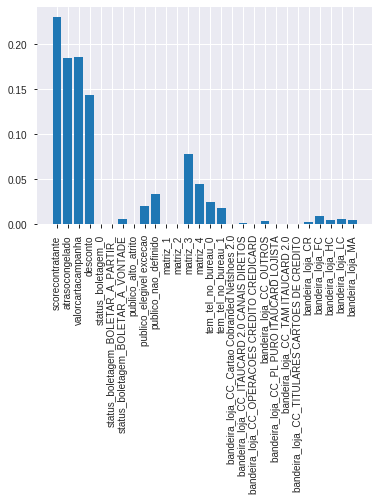

In [472]:
pyplot.bar(range(len(grid_result_xg.best_estimator_.feature_importances_)), grid_result_xg.best_estimator_.feature_importances_)
pyplot.xticks(range(len(grid_result_xg.best_estimator_.feature_importances_)),X.columns, rotation='vertical')
pyplot.show()

#### Salvando os Scalers e o Xgboosting

In [510]:
joblib.dump(escalador_vlrcartacampanha, r"models/scaler_vlrcartacampanha_a03.pkl")
joblib.dump(escalador_vlrdesconto, r"models/scaler_vlrdesconto_a03.pkl")
joblib.dump(escalador_scorecontratante, r"models/scaler_scorecontratante_a03.pkl")
joblib.dump(escalador_atrasocongelado, r"models/scaler_atrasocongelado_a03.pkl")
joblib.dump(grid_result_xg, r"models/xgboosting_a03.pkl")

['models/xgboosting_a03.pkl']